In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, quad_vec
from tqdm import tqdm
import timeit

In [2]:
"""
Constants
"""
# --> Pulse <--
wl = 0.057                      # au
epsilon = 0
intensity = 10e14 / 3.51e16     # au
phi = 0
Nc = 1
T = Nc * 2*np.pi/wl

F0 = np.sqrt(intensity)
A0 = F0 / wl

Up = A0**2 * 0.25

def envelope(t) : 
    global wl, Nc, T
    return np.sin(np.pi*t/T)**2

def A(t) : 
    global A0, epsilon, phi, Nc
    prefac = A0 * envelope(t) / ( np.sqrt( 1 + epsilon**2) )
    vec = np.array([0, epsilon*np.sin(wl*t+phi), np.cos(wl*t+phi)])
    return prefac * vec

# --> System <--
E0 = -0.5                       # au

def time_evolution(t, tp) : 
    global E0
    return np.exp( -1j*E0*(tp-t) ) 

def ground_state(r) : 
    return 1/np.sqrt(np.pi) * np.exp(r)

def ground_state_fourier(k: np.array) : 
    return 2**(5/2)/(2*np.pi) * 1/( np.dot(k,k) +1)**2

# --> Interaction <--

def interaction_vg(A, p) : 
    return np.dot(A, p) # 0.5*np.dot(A,A) --> usually set to 0

def interaction_lg(F, r) : 
    return 0


In [ ]:
def phase(t, k) : 
    global Nc
    vec = A(t) + k
    return 0.5*np.dot(vec, vec)

def volkov(t, k: np.array, t0) :
    #start = timeit.timeit()
    integral = quad(func=phase, a=t0, b=t, args=(k,))
    #end = timeit.timeit()
    #print('Volkov duration: ', end-start)
    return np.exp(1j*integral[0]) * time_evolution(t0, t)

def matrix_element(t: float, t0: float, k: np.array) : 
    callable = lambda tp, k : np.dot(k, A(tp)) * volkov(tp, k, t0)
    #start = timeit.timeit()
    tp_integral = quad(func=callable, a=t0, b=t, args=(k,), complex_func=True)
    #end = timeit.timeit()
    #print('Matrix duration: ', end-start)
    element = -1j * ground_state_fourier(k) * tp_integral[0]
    return np.abs(element)**2
    

In [22]:
def make_grid(yrange, zrange, nmb_pns) : 
    ylin = np.linspace(yrange[0], yrange[1], nmb_pns)
    zlin = np.linspace(zrange[0], zrange[1], nmb_pns)
    return ylin, zlin

threshold = 2*np.sqrt(Up)
ranges = np.array([-threshold, threshold])
pns = 60

kys, kzs = make_grid(ranges, ranges, pns)

matrix = np.zeros(shape=(pns, pns))

for i, ky in (enumerate(kys)) : 
    for j, kz in tqdm(enumerate(kzs)) : 
        matrix[i,j] = matrix_element(t=T, t0=0, k=np.array([0, ky, kz]))

0it [00:00, ?it/s]

60it [00:33,  1.77it/s]
60it [00:33,  1.77it/s]
60it [00:34,  1.76it/s]
60it [00:34,  1.75it/s]
60it [00:34,  1.76it/s]
60it [00:33,  1.79it/s]
60it [00:33,  1.80it/s]
60it [00:32,  1.83it/s]
60it [00:32,  1.84it/s]
60it [00:32,  1.87it/s]
60it [00:31,  1.89it/s]
60it [00:30,  1.94it/s]
60it [00:30,  1.98it/s]
60it [00:29,  2.04it/s]
60it [00:28,  2.12it/s]
60it [00:27,  2.19it/s]
60it [00:26,  2.25it/s]
60it [00:26,  2.30it/s]
60it [00:25,  2.36it/s]
60it [00:25,  2.40it/s]
60it [00:24,  2.50it/s]
60it [00:23,  2.56it/s]
60it [00:22,  2.61it/s]
60it [00:22,  2.63it/s]
60it [00:22,  2.64it/s]
60it [00:22,  2.61it/s]
60it [00:23,  2.61it/s]
60it [00:21,  2.74it/s]
60it [00:21,  2.77it/s]
60it [00:21,  2.78it/s]
60it [00:21,  2.77it/s]
60it [00:21,  2.75it/s]
60it [00:22,  2.71it/s]
60it [00:23,  2.58it/s]
60it [00:22,  2.64it/s]
60it [00:22,  2.63it/s]
60it [00:23,  2.59it/s]
60it [00:23,  2.59it/s]
60it [00:23,  2.55it/s]
60it [00:24,  2.44it/s]
60it [00:24,  2.45it/s]
60it [00:24,  2.

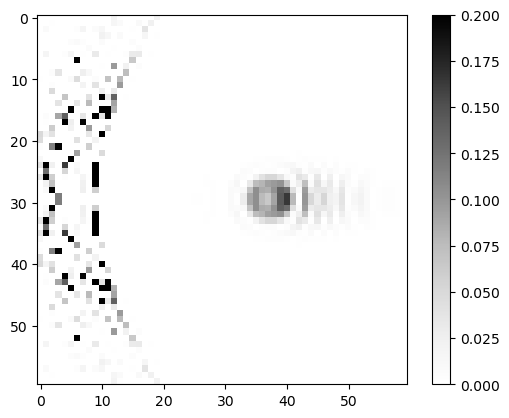

In [29]:
plt.imshow(matrix, cmap='Greys', vmax=0.2)
plt.colorbar()

In [14]:
print(matrix_element(t=T, t0=0.1, k=np.array([0,kys[0],kzs[0]])))
print(kys[0], kzs[0])

/usr/lib/python3/dist-packages/scipy/integrate/_quadpack_py.py:447: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,


0.0003000842019249969
-2.9612262195428847 -2.9612262195428847


/usr/lib/python3/dist-packages/scipy/integrate/_quadpack_py.py:450: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,


#### **VECTORIZED SOLUTION**

In [ ]:
def A(t) : 
    global A0, epsilon, phi, Nc
    prefac = A0 * envelope(t) / ( np.sqrt( 1 + epsilon**2) )

    vec = np.stack([
                    np.zeros_like(t), 
                    epsilon*np.sin(wl*t+phi),
                    np.cos(wl*t+phi)
    ], axis=0)
    return prefac * vec

def ground_state_fourier(ky: float, kzs: np.array) : 
    k2 = ky**2 + kzs**2
    return 2**(5/2)/(2*np.pi) * 1/( k2 +1)**2

def alpha(tp: float, t0: float, N: int) : 
    dt = (tp - t0) / N
    ts = np.arange(t0, tp, dt)
    A_of_ts = A(ts)
    return dt * np.sum(A_of_ts, axis=1)

def beta(tp: float, t0: float, N: int) : 
    dt = (tp - t0) / N
    ts = np.arange(t0, tp, dt)
    A_of_ts = A(ts)**2
    return dt * np.sum(A_of_ts)

def matrix_element(t: float, t0: float, ky: float, kzs: np.array, N: int) : 

    ks = np.stack([
                    np.zeros_like(kzs), 
                    ky * np.ones_like(kzs),
                    kzs
    ], axis=1)

    def integrand(tp: float) :
        A_t = A(tp)
        k_dot_A = ks @ A_t

        # trapezoid integral rule (riemann sum)
        volkov_phase = 0.5 * ks @ ks.transpose() * (tp - t0) + ks @ alpha(tp, t0, N).transpose() + beta(tp, t0, N)

        print(volkov_phase)

        volkov_state = np.exp(1j*volkov_phase*(tp - t0)) * time_evolution(tp, t0)

        return k_dot_A * volkov_state
    
    integral = quad_vec(f=integrand, a=t0, b=t)

    ground_state = ground_state_fourier(ky, kzs)
    matrix_element = -1j*ground_state*integral[0]

    return np.abs(matrix_element)**2


In [99]:
def make_grid(yrange, zrange, nmb_pns) : 
    ylin = np.linspace(yrange[0], yrange[1], nmb_pns)
    zlin = np.linspace(zrange[0], zrange[1], nmb_pns)
    return ylin, zlin

threshold = 4*np.sqrt(Up)
ranges = np.array([-threshold, threshold])
pns = 10

kys, kzs = make_grid(ranges, ranges, pns)

matrix = []

for i, ky in tqdm(enumerate(kys)) : 
    matrix.append( matrix_element(t=T, t0=0, ky=ky, kzs=kzs, N=100) )

0it [00:00, ?it/s]

[[4552.76309581 4016.69414888 3480.62520194 2944.55625501 2408.48730807
  1872.41836113 1336.3494142   800.28046726  264.21152033 -271.85742661]
 [4124.09456119 3683.28528861 3242.47601604 2801.66674346 2360.85747089
  1920.04819832 1479.23892574 1038.42965317  597.62038059  156.81110802]
 [3695.42602656 3349.87642834 3004.32683013 2658.77723192 2313.22763371
  1967.6780355  1622.12843728 1276.57883907  931.02924086  585.47964265]
 [3266.75749193 3016.46756808 2766.17764423 2515.88772038 2265.59779653
  2015.30787268 1765.01794883 1514.72802498 1264.43810113 1014.14817728]
 [2838.0889573  2683.05870781 2528.02845832 2372.99820884 2217.96795935
  2062.93770986 1907.90746037 1752.87721088 1597.84696139 1442.81671191]
 [2409.42042267 2349.64984754 2289.87927242 2230.10869729 2170.33812217
  2110.56754704 2050.79697191 1991.02639679 1931.25582166 1871.48524653]
 [1980.75188804 2016.24098728 2051.73008651 2087.21918575 2122.70828499
  2158.19738422 2193.68648346 2229.17558269 2264.66468193 

0it [00:00, ?it/s]

[[2060.14727604 1819.80429386 1579.46131168 1339.1183295  1098.77534733
   858.43236515  618.08938297  377.74640079  137.40341861 -102.93956356]
 [1859.0060393  1663.36110973 1467.71618016 1272.07125059 1076.42632102
   880.78139145  685.13646188  489.49153231  293.84660274   98.20167317]
 [1657.86480257 1506.9179256  1355.97104864 1205.02417168 1054.07729472
   903.13041776  752.18354079  601.23666383  450.28978687  299.34290991]
 [1456.72356583 1350.47474148 1244.22591712 1137.97709277 1031.72826841
   925.47944406  819.23061971  712.98179535  606.732971    500.48414664]
 [1255.58232909 1194.03155735 1132.4807856  1070.93001386 1009.37924211
   947.82847036  886.27769862  824.72692687  763.17615513  701.62538338]
 [1054.44109236 1037.58837322 1020.73565408 1003.88293494  987.03021581
   970.17749667  953.32477753  936.47205839  919.61933926  902.76662012]
 [ 853.29985562  881.14518909  908.99052256  936.83585603  964.6811895
   992.52652297 1020.37185644 1048.21718991 1076.06252338 1

KeyboardInterrupt: 

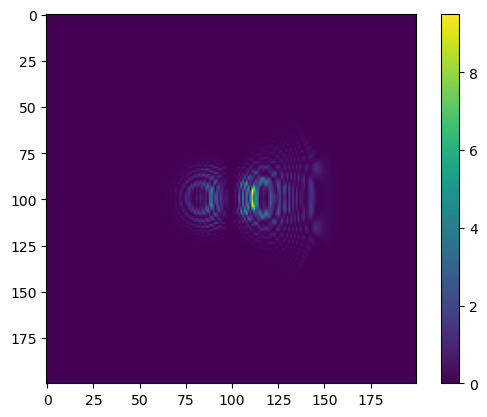

In [65]:
plt.imshow((matrix))
plt.colorbar()

In [61]:
x = [[1,2,3,4,5],[1,2,3,4,5]]

print(np.sum(x,axis=1))

[15 15]
